In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os, sys
import scipy.ndimage
import pickle
from multiprocessing import Pool
from skimage import measure, morphology
import random
import pylab
import skimage.transform

#Import Keras Libraries
from keras.applications import VGG16, Xception, ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Conv2D, Dense, Flatten
from keras_tqdm import TQDMNotebookCallback
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow, figure, hist, plot, scatter, colorbar

from PIL import Image

%matplotlib inline

np.random.seed(314159)
random.seed(314159)

Using TensorFlow backend.


In [2]:
#Set Which GPU to use. 
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
#Continue here if preprocessing data from scratch
#DATA_PATH = '/media/sohn/Storage/data_tcia_mammo/CBIS-DDSM/'
DATA_PATH = '/data/rsna_age/train/'

In [4]:
#Getting names of files in DATA_PATH
def get_file_names(path):
    x=[]
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            x.append(os.path.join(root, name))
    return x

#Read in the labels & file names
file_names = get_file_names(DATA_PATH)
df = pd.read_csv(DATA_PATH + '../age_y.csv')

In [28]:
##experiment
fn = file_names[1:100]
x=Image.open('/data/rsna_age/train/5163.png')
x = np.array(x)
x1 = skimage.transform.resize(x, (224,224), preserve_range=True)

/home/sohn/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


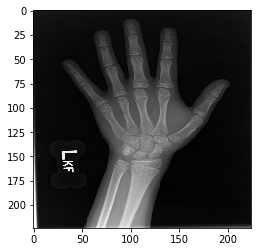

In [29]:
imshow(x1, cmap='gray')
plt.show()

In [5]:
#WARNING Take Long Time: Create an image file of all images from file_names
images = []
for fn in file_names[1:1000]:
    image = Image.open(fn)
    image = np.array(image)
    image_small = skimage.transform.resize(image, (224,224), preserve_range=True) #specify image resize
    images.append(image_small)
len(images)

/home/sohn/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


999

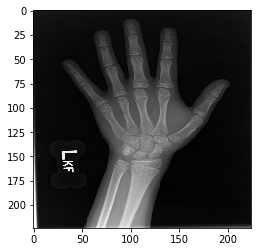

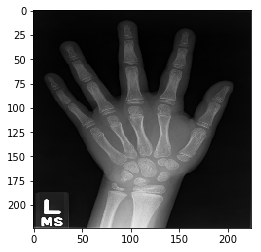

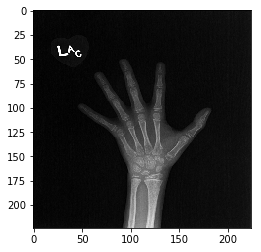

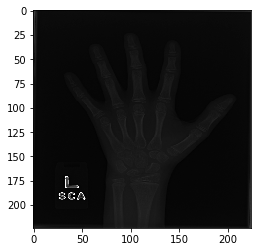

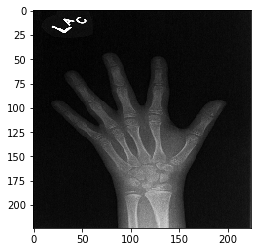

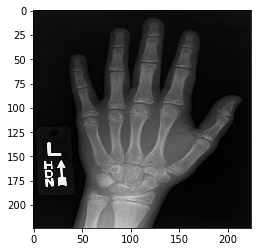

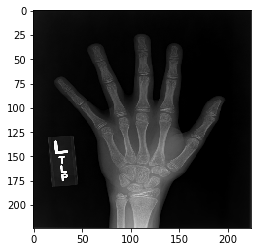

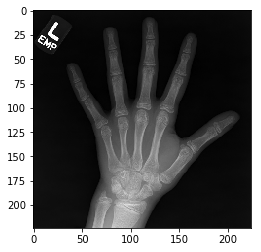

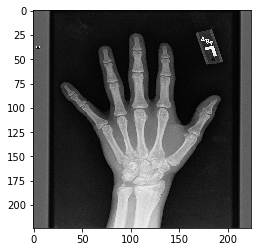

In [34]:
#Experiment
for n in range(len(images)):
    imshow(images[n], cmap='gray')
    plt.show()

In [6]:
#pull data from age_y.csv
pid = list(df["id"])
age = list(df["boneage"])
male = list(df["male"])

#Form X and Y numpy arrays from loaded image & output data
X = np.stack(images)[...,None]
X = np.repeat(X, 3, axis=-1) #because ImageNet is RGB
X = (X - np.mean(X)) / np.std(X)

y = np.asarray(age)-1
y = y[ :X.shape[0] ]

In [7]:
#Save loaded images to numpy files
np.save('/data/rsna_age/bdata_X1000.npy', X)
np.save('/data/rsna_age/bdata_y1000.npy', y)

In [19]:
#Load the saved numpy
X=np.load('/data/rsna_age/bdata_X1000.npy')
y=np.load('/data/rsna_age/bdata_y1000.npy')

Using TensorFlow backend.


In [10]:
#Import Model from Keras
#model_base = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
model_base = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
#model_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

#Add additional custom-designed top-layers
x = model_base.layers[-1].output
#x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, kernel_initializer='orthogonal', activation='relu')(x)
x = Dense(32, kernel_initializer='orthogonal', activation='relu')(x)
x = Dense(1, kernel_initializer='orthogonal')(x)
model2 = Model(model_base.inputs, x)

#Compile Model
optimizer = Adam(lr=0.0001)
#model2.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')
model2.compile(loss='mean_squared_error', metrics=['mae', 'acc'], optimizer='adam')

16/|/[loss: 1072.553]   2%|| 16/799 [00:10<00:16, 48.59it/s]

In [23]:
print(model2.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [11]:
#Train the Model
model2.fit(
    X, 
    y, 
    batch_size=16,
    epochs=10,
    validation_split=0.2,
    verbose=0, 
    callbacks=[TQDMNotebookCallback(leave_inner=True)])